In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import statsmodels.api as sma
import seaborn as sns
sns.set_theme()

In [3]:
#read file
data= pd.read_csv("Coffee_company.csv")

In [ ]:
data.head()

In [4]:
len(data.index)

1575

In [4]:
#set time index
data['Date']=data['Date'].str.replace('/', '-')
data['Date']=pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [5]:
#clean the column names, and sales columns
data.columns=data.columns.str.replace(' ', '')
data['Sales']=data['Sales'].str.replace('$', '').str.replace(',', '')

In [6]:
data['Sales']=pd.to_numeric(data['Sales'], errors='coerce')

In [7]:
#form a table
datap=pd.pivot_table(index='Date', columns='Product', values='Sales', data=data)

In [ ]:
datap.head()

In [8]:
#clean the column names
datap.columns=datap.columns.str.replace(' ', '')

In [11]:
len(datap.index)

36

In [9]:
datap['BlueMountainCoffee'].sum()

9635996.067833332

In [ ]:
#fit the data for each product
from statsmodels.api import tsa as smt
models={i:smt.ETSModel(datap[i], trend="add", seasonal="add").fit() for i in datap.columns}
fitted=pd.DataFrame({i:models[i].fittedvalues for i in models.keys()})
forecasts=pd.DataFrame({i:models[i].forecast() for i in models.keys()})
datap.index.freq='MS'

In [14]:
#check the forecast
forecasts['Arabica']

2024-01-01    261073.571464
Freq: MS, Name: Arabica, dtype: float64

<Axes: title={'center': 'Arabica Actual vs Fitted Values'}, xlabel='Date'>

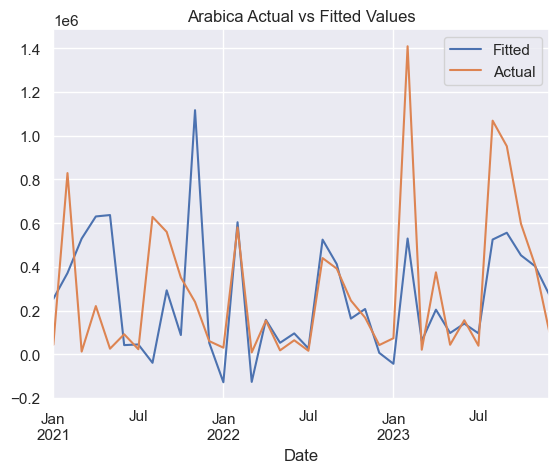

In [18]:
#check the data from the fitted model with the actual
pd.concat([fitted['Arabica'].rename('Fitted'), datap['Arabica'].rename('Actual')], axis=1).plot(title='Arabica Actual vs Fitted Values')

In [ ]:
#estimate the covariance of residuals
residuals_cov=(datap-fitted).cov()
residuals_cov

In [23]:
#check forecasts
forecasts

,Arabica,BlueMountainCoffee,Bourbon,Caturra,Robusta,Typica
2024-01-01,261073.571464,1.016148e+06,166023.973281,551984.079144,284611.643187,829612.611667


## Visualise the Distribution of Products

In [12]:
#set the seed
rng=np.random.default_rng(seed=1)

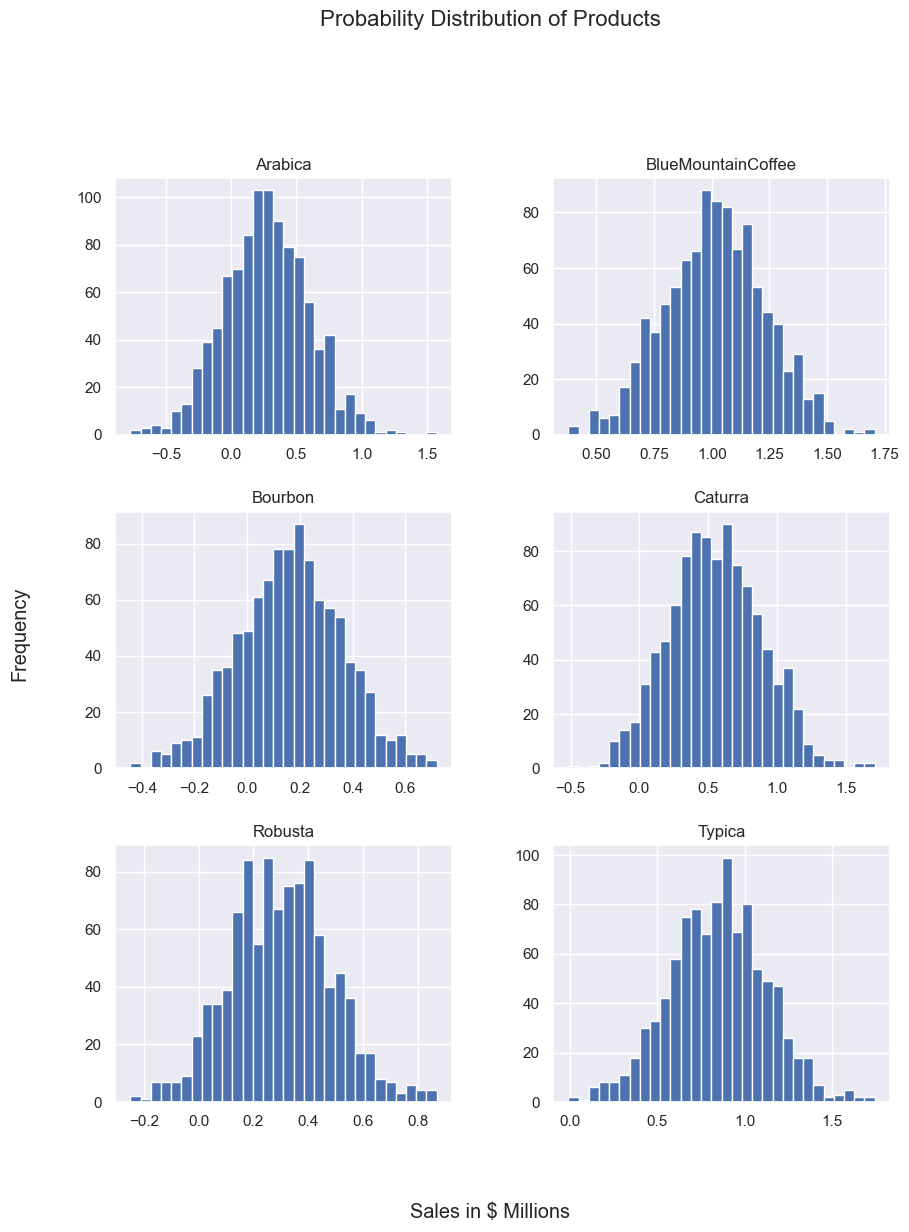

In [14]:
#shows the probability distribution of forecasted values based on randomly generated numbers of the forecasts and the covariance matrix
#produce forecast distribution for each product
n_sample=1000
datap_sim=rng.multivariate_normal(forecasts.values.squeeze(), residuals_cov, size=n_sample)
dist_fore=pd.DataFrame(datap_sim, columns=forecasts.columns)
dist_fore_m = dist_fore / 1e6  #Convert to millions
dist_fore1 = dist_fore_m.hist(figsize=(10,12), bins=30)

fig = dist_fore1[0][0].figure  #Get the figure object from any axis

# Set a super title and shared axis labels
fig.suptitle('Probability Distribution of Products', fontsize=16, y=1.02)
fig.supxlabel('Sales in $ Millions')
fig.supylabel('Frequency')

mp.show()

In [15]:
#calculate standard deviation of forecasted values
std_val=dist_fore.std()
std_val_ind=pd.DataFrame([std_val], columns=std_val.index)
std_val_ind

,Arabica,BlueMountainCoffee,Bourbon,Caturra,Robusta,Typica
0,324877.613534,217334.221662,198999.805654,333826.073015,186407.01179,277990.46397


In [16]:
#sample the regression parameters - this will show us the distribution of the forecasted sales for the new year with randomly simulated numbers
a=rng.normal(forecasts['Arabica'], std_val_ind['Arabica'], size=n_sample)
b=rng.normal(forecasts['BlueMountainCoffee'], std_val_ind['BlueMountainCoffee'], size=n_sample)
br=rng.normal(forecasts['Bourbon'], std_val_ind['Bourbon'], size=n_sample)
c=rng.normal(forecasts['Caturra'], std_val_ind['Caturra'], size=n_sample)
r=rng.normal(forecasts['Robusta'], std_val_ind['Robusta'], size=n_sample)
t=rng.normal(forecasts['Typica'], std_val_ind['Typica'], size=n_sample)

In [17]:
#calculate the distribution of total sales
total_sales=(a*dist_fore['Arabica']+b*dist_fore['BlueMountainCoffee']+br*dist_fore['Bourbon']+c*dist_fore['Caturra']+r*dist_fore['Robusta']+t*dist_fore['Typica'])

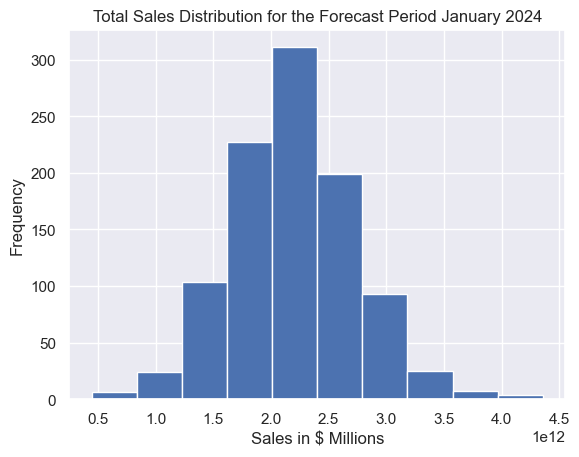

In [18]:
pd.Series(total_sales).hist()
mp.title('Total Sales Distribution for the Forecast Period January 2024')  
mp.xlabel('Sales in $ Millions')                  
mp.ylabel('Frequency')
mp.show()

## Profit Predictions using Classification

In [ ]:
#data cleaning and sorting
data.head()

In [19]:
#clean profit data 
data['Profit']=data['Profit'].str.replace('$', '').str.replace(',', '')
data['ManufacturingPrice']=data['ManufacturingPrice'].str.replace('$', '').str.replace(',', '')
data['SalePrice']=data['SalePrice'].str.replace('$', '').str.replace(',', '')

In [20]:
#change to numeric
data['Profit']=pd.to_numeric(data['Profit'], errors='coerce')
data['ManufacturingPrice']=pd.to_numeric(data['ManufacturingPrice'], errors='coerce')
data['SalePrice']=pd.to_numeric(data['SalePrice'], errors='coerce')

In [ ]:
ndata=data[['Country', 'Profit', 'ManufacturingPrice', 'SalePrice']]
ndata=ndata.set_index('Country').reset_index()
ndata.head()
x_var=['Profit', 'ManufacturingPrice', 'SalePrice']
ndata.head()

In [22]:
#create imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') #startegy='most_frequent' for categorical 
#apply imputer to specified columns in ndata
ndata[x_var]=imputer.fit_transform(ndata[x_var])

In [23]:
#import matplotlib
import matplotlib.pyplot as plt

#train data splitting into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(ndata, test_size=0.1, random_state=1, stratify=ndata['Country'])

In [24]:

#standardise the data
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
train_std=scaler.fit_transform(train[x_var])
test_std=scaler.transform(test[x_var])

In [25]:

#write the logical regression model
from sklearn.linear_model import LogisticRegression
logrg=LogisticRegression()
model=logrg.fit(train_std, train['Country'])

#prediction and misclassification
lgtest=test.copy()
lgtest['Prediction'] = model.predict(test_std)
lgtest['Misclass'] = (lgtest['Prediction'] != lgtest['Country'])

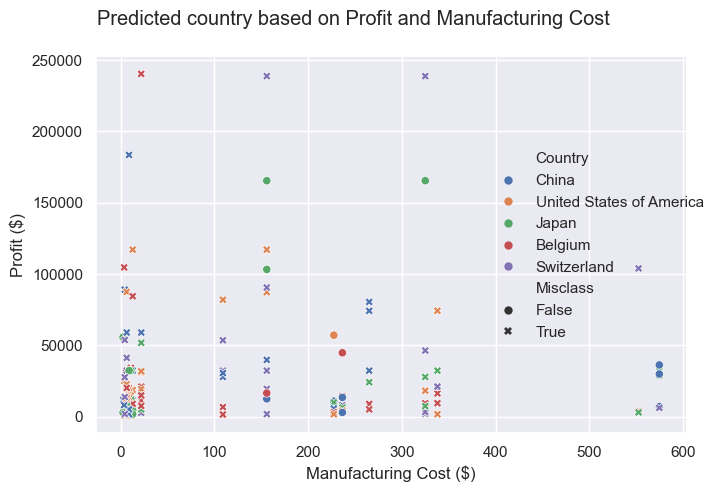

In [26]:
#visualisation
ax = sns.relplot(data=lgtest, x='ManufacturingPrice', y='Profit', hue='Country', style='Misclass')
ax.figure.suptitle('Predicted country based on Profit and Manufacturing Cost')
ax.set_axis_labels('Manufacturing Cost ($)', 'Profit ($)')
ax.figure.tight_layout()
plt.show()

#true means that the prediction is correct according to Country test data
#false means that the prediction is not correct

## Demand Modelling using Randomly Generated Numbers

In [66]:
#simple linear regression with visualisation
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as smt
import pandas as pd
import matplotlib.pyplot as plt
import random

#generate two sets of data and put them in a df
dict_new = {'Price': [random.randint(10, 20) for _ in range(40)], 'Demand': [random.randint(1, 500) for _ in range(40)]}

new_df=pd.DataFrame(dict_new)
new_df.head()

,Price,Demand
0,14,227
1,12,489
2,13,167
3,16,141
4,20,331


The model predicts the Demand to be 216.10 when the Price is £16.


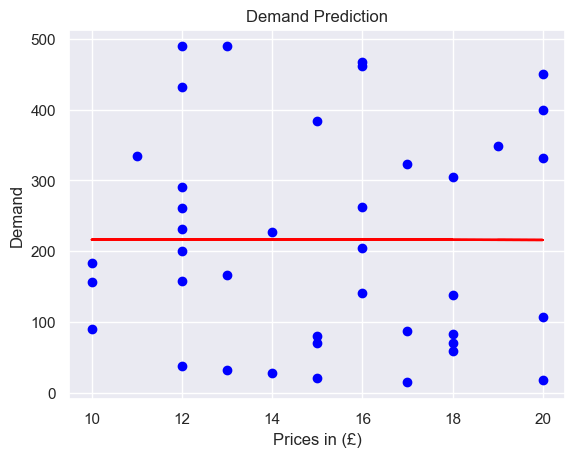

In [72]:
#define variables
x_var=new_df[['Price']]
y_var=new_df['Demand']


#fit the model in linear regression
lnr=LinearRegression()
modl=lnr.fit(x_var, y_var)

#predict the values
pred_df=pd.DataFrame({'Price':[16]})
pred_val=modl.predict(pred_df)
print(f'The model predicts the Demand to be {pred_val[0]:.2f} when the Price is £16.')

#plot the data
plt.scatter(x_var, y_var, color='blue')
plt.plot(x_var, modl.predict(x_var), color='red')
plt.xlabel('Prices in (£)')
plt.ylabel('Demand')
plt.title('Demand Prediction')
plt.show()